In [17]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import os

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import itertools

%matplotlib inline

In [4]:
batch_size = 32  # The default batch size of keras.
num_classes = 10  # Number of class for the dataset
epochs = 55

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Normalize the data. Before we need to connvert data type to float for computation.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices. This is called one hot encoding.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
#define the convnet
model = Sequential()
# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# FLATTERN => DENSE => RELU => DROPOUT
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# a softmax classifier
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [7]:
# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [9]:

data_augmentation = False # not data augmentation
history = None
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:

    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                    batch_size=batch_size),
                                    epochs=epochs,
                                    validation_data=(x_test, y_test),
                                    workers=4)

Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/55
50000/50000 [==============================] - 10s 199us/step - loss: 1.0068 - accuracy: 0.6482 - val_loss: 0.9659 - val_accuracy: 0.6646
Epoch 2/55
50000/50000 [==============================] - 11s 210us/step - loss: 0.9631 - accuracy: 0.6639 - val_loss: 0.9079 - val_accuracy: 0.6844
Epoch 3/55
50000/50000 [==============================] - 11s 215us/step - loss: 0.9307 - accuracy: 0.6732 - val_loss: 0.8634 - val_accuracy: 0.6996
Epoch 4/55
50000/50000 [==============================] - 10s 201us/step - loss: 0.9005 - accuracy: 0.6857 - val_loss: 0.8434 - val_accuracy: 0.7041
Epoch 5/55
50000/50000 [==============================] - 10s 205us/step - loss: 0.8691 - accuracy: 0.6947 - val_loss: 0.8445 - val_accuracy: 0.7109
Epoch 6/55
50000/50000 [==============================] - 10s 200us/step - loss: 0.8519 - accuracy: 0.7027 - val_loss: 0.8361 - val_accuracy: 0.7138
Epoch 7/55
50000/50000 [===

50000/50000 [==============================] - 11s 221us/step - loss: 0.6207 - accuracy: 0.7932 - val_loss: 0.6953 - val_accuracy: 0.7842


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


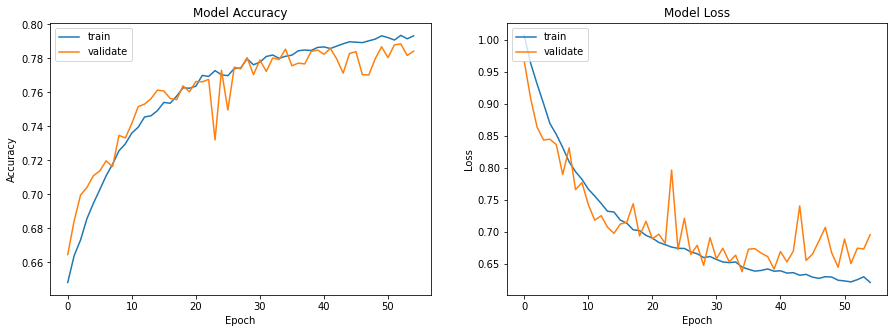

In [10]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())

plotmodelhistory(history)

In [11]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model.predict(x_test)

10000/10000 [==============================] - 1s 92us/step
Test loss: 0.6952560681343078
Test accuracy: 0.7842000126838684


In [12]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

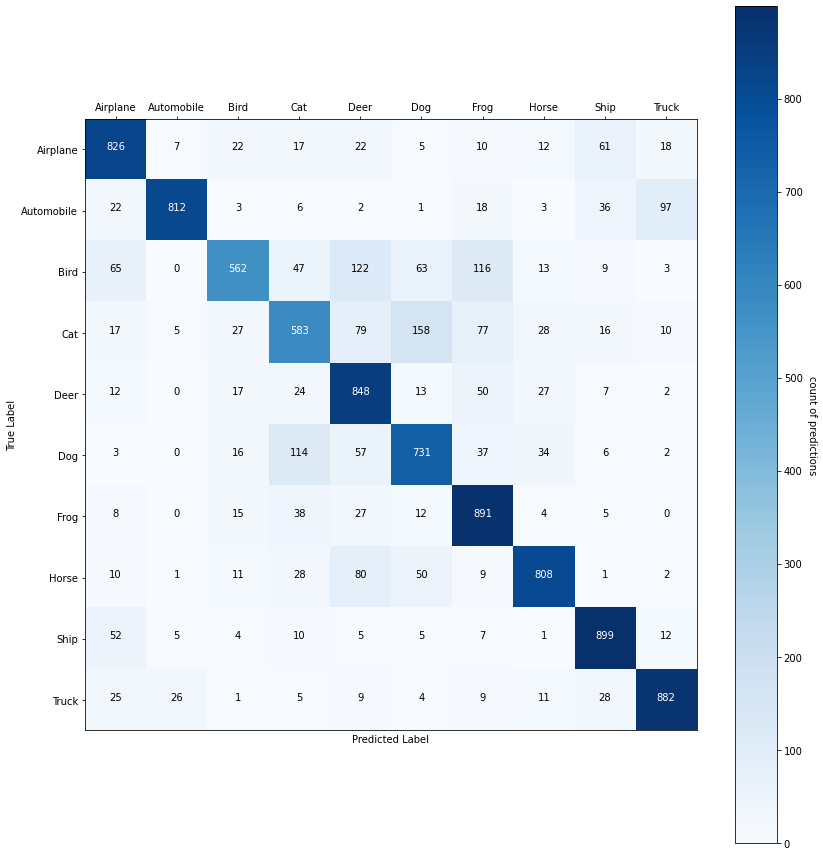

In [13]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

In [35]:
#NEXT CNN MODEL WITH DATA AUGEMENTATION , EARLY STOPPING , BATCH NORMALIZATION , ADAM OPTIMIZER, learning rate = 0.0005

In [24]:
#define the convnet
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Conv2D(32, (3, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(64, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Conv2D(64, (3, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(512))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))

model1.add(Dense(num_classes))
model1.add(Activation('softmax'))

In [25]:
opt = keras.optimizers.Adam(learning_rate=0.0005, decay=1e-6)

# Let's train the model using RMSprop
model1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [40]:
print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)
datagen.fit(x_test)

Using real-time data augmentation.


In [27]:
from tensorflow.keras.callbacks import EarlyStopping
early = EarlyStopping(patience=12)
his = model1.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), validation_data = datagen.flow(x_test, y_test, batch_size=batch_size), epochs=epochs, callbacks = [early],workers=4)

Epoch 1/55
1563/1563 [==============================] - 52s 33ms/step - loss: 2.0766 - accuracy: 0.3190 - val_loss: 1.2349 - val_accuracy: 0.3878
Epoch 2/55
1563/1563 [==============================] - 52s 33ms/step - loss: 1.6000 - accuracy: 0.4251 - val_loss: 1.6386 - val_accuracy: 0.4583
Epoch 3/55
1563/1563 [==============================] - 52s 33ms/step - loss: 1.4620 - accuracy: 0.4719 - val_loss: 1.4819 - val_accuracy: 0.5041
Epoch 4/55
1563/1563 [==============================] - 52s 33ms/step - loss: 1.3709 - accuracy: 0.5089 - val_loss: 1.5440 - val_accuracy: 0.5327
Epoch 5/55
1563/1563 [==============================] - 52s 33ms/step - loss: 1.2964 - accuracy: 0.5349 - val_loss: 1.3380 - val_accuracy: 0.5779
Epoch 6/55
1563/1563 [==============================] - 54s 35ms/step - loss: 1.2451 - accuracy: 0.5576 - val_loss: 1.4417 - val_accuracy: 0.5946
Epoch 7/55
1563/1563 [==============================] - 54s 35ms/step - loss: 1.1973 - accuracy: 0.5745 - val_loss: 1.0937 -

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


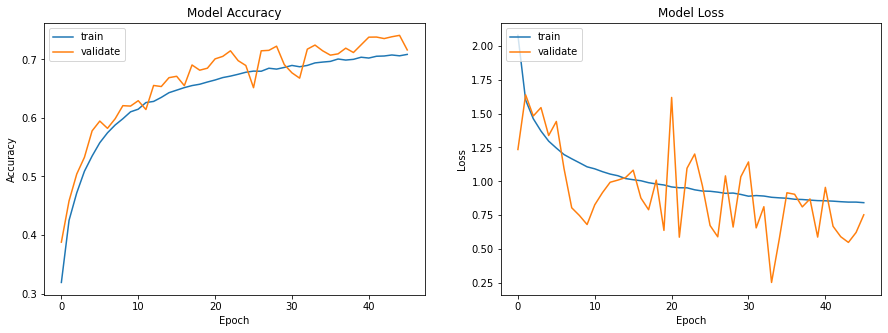

In [30]:
def plotmodelhistory(his): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(his.history['accuracy']) 
    axs[0].plot(his.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(his.history['loss']) 
    axs[1].plot(his.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(his.history.keys())

plotmodelhistory(his)

In [36]:
# NEXT CNN MODEL

In [47]:
mode = Sequential()

mode.add(Conv2D(filters = 32,input_shape = (32,32,3),kernel_size=(3,3),padding = 'same',activation='relu'))
mode.add(Dropout(0.3))

mode.add(Conv2D(filters = 32,kernel_size=(3,3),padding = 'same',activation='relu'))
mode.add(MaxPooling2D(pool_size=(2,2)))

mode.add(Conv2D(filters = 64,kernel_size=(3,3),padding = 'same',activation='relu'))
mode.add(Dropout(0.3))

mode.add(Conv2D(filters = 64,kernel_size=(3,3),padding = 'same',activation='relu'))
mode.add(MaxPooling2D(pool_size=(2,2)))

mode.add(Conv2D(filters = 128,kernel_size=(3,3),padding = 'same',activation='relu'))
mode.add(Dropout(0.3))

mode.add(Conv2D(filters = 128,kernel_size=(3,3),padding = 'same',activation='relu'))
mode.add(MaxPooling2D(pool_size=(2,2)))

mode.add(Flatten())
mode.add(Dropout(0.5))
mode.add(Dense(2500,activation='relu'))
mode.add(Dropout(0.3))
mode.add(Dense(1500,activation='relu'))
mode.add(Dropout(0.3))
mode.add(Dense(10,activation='softmax'))


In [42]:
mode.compile(loss = 'categorical_crossentropy'
             ,optimizer = 'adam',metrics = ['accuracy'])

In [43]:
history1 = mode.fit(x_train,y_train,validation_data=(x_test, y_test),epochs = 50,batch_size=300,verbose = 1,)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 130us/step - loss: 1.7928 - accuracy: 0.3358 - val_loss: 1.5604 - val_accuracy: 0.4465
Epoch 2/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.3240 - accuracy: 0.5190 - val_loss: 1.1638 - val_accuracy: 0.5726
Epoch 3/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.0838 - accuracy: 0.6118 - val_loss: 1.0060 - val_accuracy: 0.6433
Epoch 4/50
50000/50000 [==============================] - 5s 107us/step - loss: 0.9194 - accuracy: 0.6747 - val_loss: 0.9216 - val_accuracy: 0.6756
Epoch 5/50
50000/50000 [==============================] - 5s 105us/step - loss: 0.8084 - accuracy: 0.7145 - val_loss: 0.8041 - val_accuracy: 0.7170
Epoch 6/50
50000/50000 [==============================] - 5s 108us/step - loss: 0.7004 - accuracy: 0.7537 - val_loss: 0.7242 - val_accuracy: 0.7492
Epoch 7/50
50000/50000 [==============================] - 5s 1

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


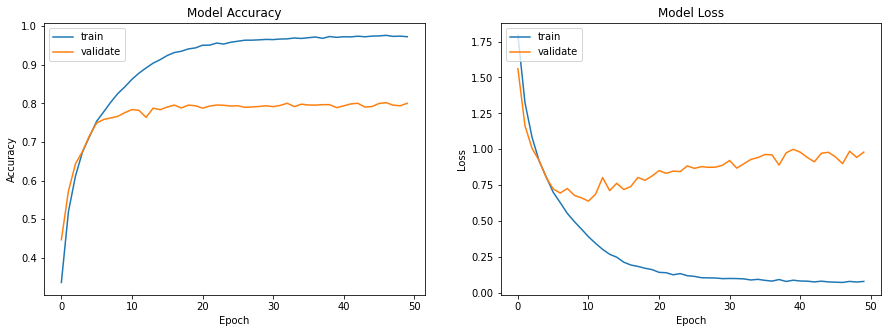

In [44]:
def plotmodelhistory(history1): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history1.history['accuracy']) 
    axs[0].plot(history1.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history1.history['loss']) 
    axs[1].plot(history1.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history1.history.keys())

plotmodelhistory(history1)

In [46]:
scores = mode.evaluate(x_test,y_test,verbose = 0)
scores[1]

0.8003000020980835

In [ ]:
#SAVE THE MODEL

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])